In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

from timeit import default_timer as timer 

#import functions from modular
import modular.samples_setup as cs
from modular import engine
from modular import extra_functions as ef

## Perform some simulations

We will create two classes: circles and squares.

We change the orientation and size. 
For some of them we add some noise (Gaussian) 



In [3]:
output = cs.generate_sample(n=[20]*2, seed=11, noise_prop=0.5, var=0.35)
images, labels= (output['images'], output['labels'])

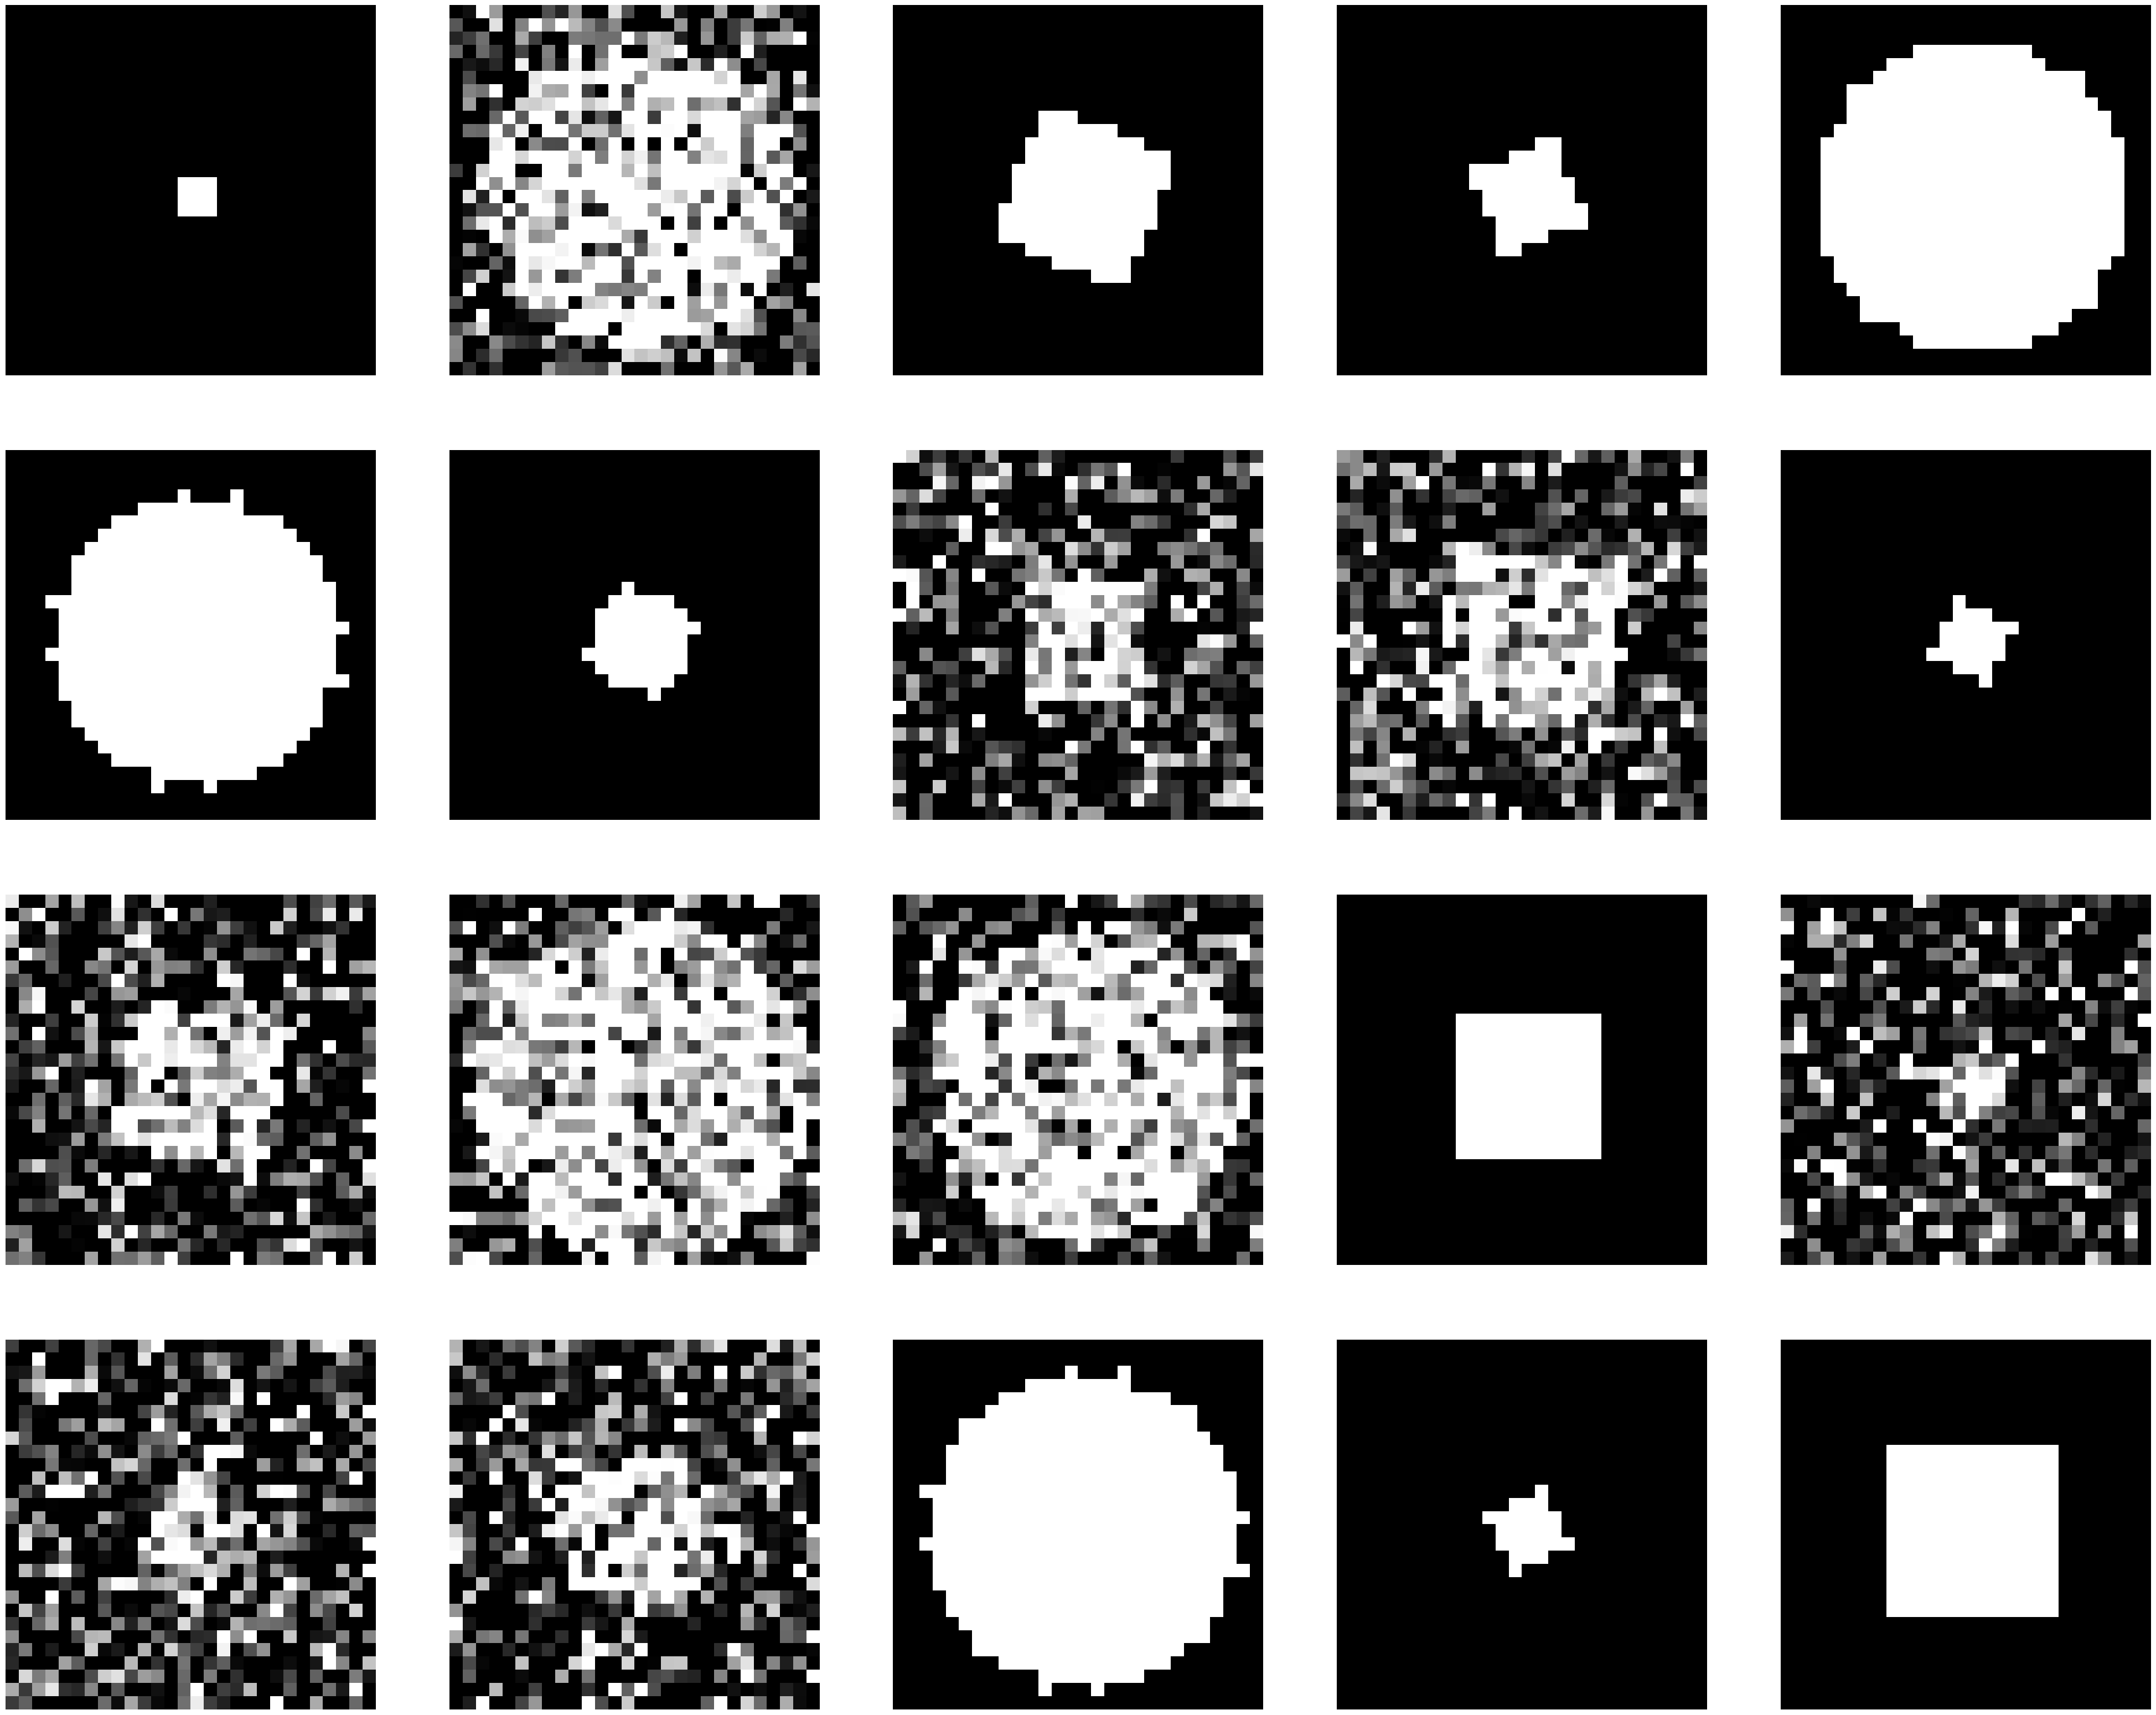

In [4]:
fig, axes = plt.subplots(4, 5, figsize=(50,40))
    
# Flatten the axes array for easier looping
axes = axes.flatten()
    
# Loop through images and axes
for i in range(20):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].axis('off')  # Hide the axes for each image



### Define NN

In [5]:
class classificador(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # Flatten the output from the convolutional layers into a 1D vector
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,  
                      out_features=output_shape) # Fully connected layer
        )
    
    def forward(self, x: torch.Tensor):
        #print(x.shape)
        x = self.block_1(x)
        #print(x.shape)
        x = self.block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x


torch.manual_seed(42)

model_1 =  classificador(input_shape=1, hidden_units= 10, output_shape=2)
model_1

classificador(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=2, bias=True)
  )
)

In [6]:
loss_fn = nn.CrossEntropyLoss()
# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc


## Simulate data without noise and train the model

In [11]:
output = cs.generate_sample(n = [10000]*2,noise_prop=0, var=0)
images, labels= (output['images'], output['labels'])
train_dataset, test_dataset = cs.generate_dataset(images, labels)
        
train_dataloader = DataLoader(train_dataset, 
                              batch_size= 32, 
                              shuffle=True)
                             
test_dataloader = DataLoader(test_dataset,
                             batch_size= 32,
                             shuffle=True )
            
result = engine.train_test_loop(model_1,train_dataloader,test_dataloader,
                                optimizer, loss_fn, 5,print_b=False)

In [12]:
result['test_acc'][4]

97.55

## Experiment 1

We want to measure the performance of the model when the noise is only present in the 
test data set. Meaning: we trained the model with a good data set and then we want to predict noisy data. 

We vary the total sample size and amout of error. We train the model for each combination and we the assess is performance by getting the test accuracy. 





In [15]:

n_samples = [[500]*2, [1000]*2, [2500]*2,[5000]*2] # for each class
vars = np.array([0,0.05,0.1,0.25])
accuracy_test = np.zeros((len(n_samples),len(vars)))

#train_dataset, test_dataset = cs.generate_dataset(images, labels)


[500, 500]

In [23]:
from torch.utils.data import DataLoader
from timeit import default_timer as timer 
from tqdm.auto import tqdm

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 5

for n in range(len(n_samples)):
    for v in range(len(vars)):
        images, labels = cs.generate_sample(n_samples[n], 0,var=0)
        
        # split test and train
        n_test = int(2*n_samples[n]*0.2)
        test_index = np.arange(n_test)
        train_index = np.arange(n_test, n_samples[n]*2)

        images_test = images[test_index]
        images_train = images[train_index]

        label_test = labels[test_index]
        label_train = labels[train_index]
        
        # Adding noise only to the test set
        
        n_noisy = int (n_test)
        #noisy_indices = np.random.choice(n_test, n_noisy, replace=False)
        #for i in noisy_indices:
        for i in range(len(images_test)):
            images_test[i] = ef.add_gaussian_noise(images_test[i],var=vars[v])

        # create tensor
        X_test = torch.from_numpy(images_test).type(torch.float)
        X_train = torch.from_numpy(images_train).type(torch.float)

        y_train = torch.from_numpy(label_train).type(torch.long)
        y_test = torch.from_numpy(label_test).type(torch.long)

        ## Add channel at dimension 1 (greyscale)

        X_train = X_train.unsqueeze(1)  
        X_test = X_test.unsqueeze(1)  
            
        train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
        test_dataset = torch.utils.data.TensorDataset(X_test,y_test)
             
      
        # create data loader
        # Turn datasets into iterables (batches)
        train_dataloader = DataLoader(train_dataset, # dataset to turn into iterable  
        batch_size=BATCH_SIZE, # how many samples per batch? 
        shuffle=True # shuffle data every epoch?
        )

        test_dataloader = DataLoader(test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False # don't necessarily have to shuffle the testing data
        )
        
        # test_acc, test_loss,test_pred = ttl.train_test_loop(epochs,train_dataloader,
        #                                           test_dataloader, model_1,
        #                                           optimizer,loss_fn)
        
        # accuracy_test[n,v] = test_acc
        
        
        
    # Create training and testing loop
        for epoch in tqdm(range(epochs)):
            #print(f"Epoch: {epoch}\n-------")
            ### Training
            train_loss = 0
            # Add a loop to loop through training batches
            for batch, (X, y) in enumerate(train_dataloader):
                model_1.train() 
                # 1. Forward pass
                y_pred = model_1(X)

                # 2. Calculate loss (per batch)
                loss = loss_fn(y_pred, y)
                train_loss += loss # accumulatively add up the loss per epoch 

                # 3. Optimizer zero grad
                optimizer.zero_grad()

                # 4. Loss backward
                loss.backward()

                # 5. Optimizer step
                optimizer.step()

                
            # Divide total train loss by length of train dataloader (average loss per batch per epoch)
            train_loss /= len(train_dataloader)
            
            ### Testing
            # Setup variables for accumulatively adding up loss and accuracy 
            test_loss, test_acc = 0, 0 
            model_1.eval()
            with torch.inference_mode():
                for X, y in test_dataloader:
                    # 1. Forward pass
                    test_pred = model_1(X)
                
                    # 2. Calculate loss (accumatively)
                    test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

                    # 3. Calculate accuracy (preds need to be same as y_true)
                    test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
                
                # Calculations on test metrics need to happen inside torch.inference_mode()
                # Divide total test loss by length of test dataloader (per batch)
                test_loss /= len(test_dataloader)

                # Divide total accuracy by length of test dataloader (per batch)
                test_acc /= len(test_dataloader)

            # Print out what's happening
            #print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

        accuracy_test[n,v] = test_acc

  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.66778 | Test loss: 0.55499, Test acc: 75.45%


Train loss: 0.56446 | Test loss: 0.62762, Test acc: 64.73%


Train loss: 0.53900 | Test loss: 0.52725, Test acc: 75.45%


Train loss: 0.52031 | Test loss: 0.49808, Test acc: 75.45%


Train loss: 0.52054 | Test loss: 0.50809, Test acc: 74.11%



  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.54953 | Test loss: 0.60929, Test acc: 67.86%


Train loss: 0.54652 | Test loss: 0.59166, Test acc: 69.20%


Train loss: 0.54014 | Test loss: 0.61224, Test acc: 66.96%


Train loss: 0.54051 | Test loss: 0.62071, Test acc: 66.52%


Train loss: 0.55126 | Test loss: 0.62580, Test acc: 66.07%



  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.55559 | Test loss: 0.57556, Test acc: 69.64%


Train loss: 0.55568 | Test loss: 0.59146, Test acc: 65.18%


Train loss: 0.54827 | Test loss: 0.61664, Test acc: 63.84%


Train loss: 0.55036 | Test loss: 0.72542, Test acc: 56.25%


Train loss: 0.57103 | Test loss: 0.55913, Test acc: 70.09%



  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.54458 | Test loss: 0.49191, Test acc: 76.34%


Train loss: 0.54205 | Test loss: 0.61778, Test acc: 65.18%


Train loss: 0.54298 | Test loss: 0.49765, Test acc: 76.79%


Train loss: 0.54178 | Test loss: 0.50452, Test acc: 75.45%


Train loss: 0.52855 | Test loss: 0.52966, Test acc: 74.55%



  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.52318 | Test loss: 0.51800, Test acc: 66.35%


Train loss: 0.52024 | Test loss: 0.51986, Test acc: 73.32%


Train loss: 0.51502 | Test loss: 0.52582, Test acc: 69.71%


Train loss: 0.51009 | Test loss: 0.50633, Test acc: 73.32%


Train loss: 0.50620 | Test loss: 0.50813, Test acc: 72.12%



  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.49969 | Test loss: 0.59884, Test acc: 65.62%


Train loss: 0.49085 | Test loss: 0.57103, Test acc: 66.83%


Train loss: 0.48152 | Test loss: 0.56001, Test acc: 67.55%


Train loss: 0.46862 | Test loss: 0.58094, Test acc: 66.35%


Train loss: 0.44690 | Test loss: 0.53080, Test acc: 69.23%



  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.41252 | Test loss: 0.66514, Test acc: 65.38%


Train loss: 0.34382 | Test loss: 0.68004, Test acc: 67.55%


Train loss: 0.29613 | Test loss: 0.75477, Test acc: 65.62%


Train loss: 0.24431 | Test loss: 0.76116, Test acc: 69.47%


Train loss: 0.21657 | Test loss: 0.91835, Test acc: 64.66%



  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.17806 | Test loss: 1.42658, Test acc: 64.66%


Train loss: 0.17569 | Test loss: 1.11940, Test acc: 64.42%


Train loss: 0.11373 | Test loss: 1.22032, Test acc: 63.46%


Train loss: 0.12788 | Test loss: 1.39403, Test acc: 63.22%


Train loss: 0.13145 | Test loss: 1.28330, Test acc: 65.87%



  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.10432 | Test loss: 0.08831, Test acc: 97.66%


Train loss: 0.10557 | Test loss: 0.08554, Test acc: 97.17%


Train loss: 0.08721 | Test loss: 0.09090, Test acc: 96.97%


Train loss: 0.08923 | Test loss: 0.07743, Test acc: 97.46%


Train loss: 0.08255 | Test loss: 0.08167, Test acc: 96.19%



  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.09899 | Test loss: 1.77261, Test acc: 64.94%


Train loss: 0.11564 | Test loss: 1.63079, Test acc: 65.82%


Train loss: 0.09380 | Test loss: 1.60651, Test acc: 65.82%


Train loss: 0.09170 | Test loss: 1.45812, Test acc: 65.72%


Train loss: 0.09286 | Test loss: 1.68680, Test acc: 64.45%



  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.08650 | Test loss: 1.61972, Test acc: 63.57%


Train loss: 0.08863 | Test loss: 1.69615, Test acc: 66.11%


Train loss: 0.08400 | Test loss: 1.74077, Test acc: 65.43%


Train loss: 0.08221 | Test loss: 1.51491, Test acc: 63.57%


Train loss: 0.08209 | Test loss: 1.74698, Test acc: 63.96%



  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.08427 | Test loss: 1.79648, Test acc: 63.48%


Train loss: 0.08258 | Test loss: 1.58680, Test acc: 65.04%


Train loss: 0.07973 | Test loss: 1.70961, Test acc: 64.45%


Train loss: 0.08358 | Test loss: 1.55083, Test acc: 63.57%


Train loss: 0.08622 | Test loss: 1.53169, Test acc: 65.62%



  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.07887 | Test loss: 0.07406, Test acc: 97.57%


Train loss: 0.08129 | Test loss: 0.07418, Test acc: 97.52%


Train loss: 0.07933 | Test loss: 0.07148, Test acc: 97.62%


Train loss: 0.07873 | Test loss: 0.07398, Test acc: 97.47%


Train loss: 0.07743 | Test loss: 0.07984, Test acc: 97.52%



  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.07818 | Test loss: 1.52966, Test acc: 64.53%


Train loss: 0.07672 | Test loss: 1.72638, Test acc: 64.83%


Train loss: 0.07681 | Test loss: 1.70467, Test acc: 65.38%


Train loss: 0.07559 | Test loss: 1.48398, Test acc: 65.53%


Train loss: 0.07653 | Test loss: 1.69555, Test acc: 66.37%



  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.07432 | Test loss: 1.67011, Test acc: 63.14%


Train loss: 0.07517 | Test loss: 1.52355, Test acc: 62.90%


Train loss: 0.07591 | Test loss: 1.53738, Test acc: 62.50%


Train loss: 0.07479 | Test loss: 1.55724, Test acc: 62.25%


Train loss: 0.07533 | Test loss: 1.58041, Test acc: 61.76%



  0%|          | 0/5 [00:00<?, ?it/s]


Train loss: 0.07985 | Test loss: 1.81880, Test acc: 61.16%


Train loss: 0.07887 | Test loss: 1.59529, Test acc: 61.11%


Train loss: 0.07857 | Test loss: 1.58947, Test acc: 62.65%


Train loss: 0.07704 | Test loss: 1.74676, Test acc: 62.85%


Train loss: 0.07889 | Test loss: 1.53844, Test acc: 63.34%



In [26]:
accuracy_test[1,]

array([72.11538462, 69.23076923, 64.66346154, 65.86538462])

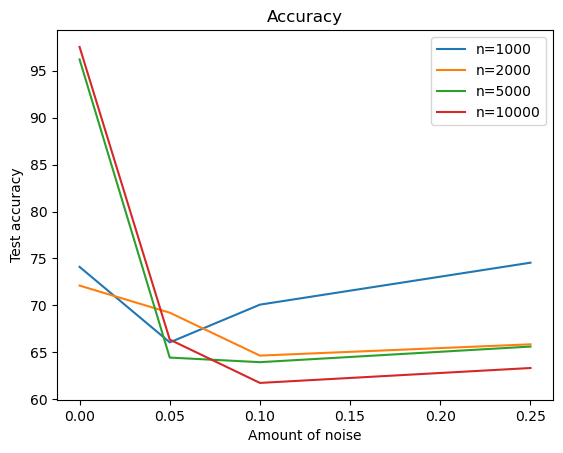

In [27]:
## PLotconsidering one realization per scenario
plt.plot(vars, accuracy_test[0,],label = f'n={n_samples[0]}')
plt.plot(vars, accuracy_test[1,],label = f'n={n_samples[1]}')
plt.plot(vars, accuracy_test[2,],label = f'n={n_samples[2]}')
plt.plot(vars, accuracy_test[3,],label = f'n={n_samples[3]}')
plt.xlabel('Amount of noise')
plt.ylabel('Test accuracy')
plt.title('Accuracy')
plt.legend()

## Experiment 2

Now we want to measure the performance of the model when we train the model only with noisy data
Meaning: we trained the model with a noisy data set and then we want to predict good data. 

We vary the total sample size and amout of error. We train the model for each combination and we the assess is performance by getting the test accuracy. 


Note: Just one realization per scenario


In [11]:

n_samples = [[500]*2, [1000]*2, [2500]*2,[5000]*2] # for each class
vars = np.array([0,0.05,0.1,0.25])
accuracy_test_exp2 = np.zeros((len(n_samples),len(vars)))


## Experiment 3

Now lest assume that we shuffle the data set. So we have noise data in the test and train set. 

With the error rate fixed, we vary the total sample size and the proportion of noisy data. We train the model for each combination and we the assess is performance by getting the test accuracy. 



Note: Just one realization per scenario


In [9]:

noise_props = np.array([0,0.1,0.35,0.5,0.75,0.90,0.99])
n_samples = n_samples = [[500]*2, [1000]*2, [2500]*2,[5000]*2] # for each class
accuracy_test = np.zeros((len(n_samples),len(noise_props)))
var = 0.25
#train_dataset, test_dataset = cs.generate_dataset(images, labels)

In [10]:
from torch.utils.data import DataLoader
from timeit import default_timer as timer 
from tqdm.auto import tqdm


# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 5

for n in range(len(n_samples)):
    for i in range(len(noise_props)):
        images, labels = cs.generate_sample(n_samples[n], noise_props[i],var=var)
        train_dataset, test_dataset = cs.generate_dataset(images, labels)
        
        
        # create data loader
        # Turn datasets into iterables (batches)
        train_dataloader = DataLoader(train_dataset, # dataset to turn into iterable  
        batch_size=BATCH_SIZE, # how many samples per batch? 
        shuffle=True # shuffle data every epoch?
        )

        test_dataloader = DataLoader(test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False # don't necessarily have to shuffle the testing data
        )
        
        
    # Create training and testing loop
        for epoch in tqdm(range(epochs)):
            #print(f"Epoch: {epoch}\n-------")
            ### Training
            train_loss = 0
            # Add a loop to loop through training batches
            for batch, (X, y) in enumerate(train_dataloader):
                model_1.train() 
                # 1. Forward pass
                y_pred = model_1(X)

                # 2. Calculate loss (per batch)
                loss = loss_fn(y_pred, y)
                train_loss += loss # accumulatively add up the loss per epoch 

                # 3. Optimizer zero grad
                optimizer.zero_grad()

                # 4. Loss backward
                loss.backward()

                # 5. Optimizer step
                optimizer.step()

                
            # Divide total train loss by length of train dataloader (average loss per batch per epoch)
            train_loss /= len(train_dataloader)
            
            ### Testing
            # Setup variables for accumulatively adding up loss and accuracy 
            test_loss, test_acc = 0, 0 
            model_1.eval()
            with torch.inference_mode():
                for X, y in test_dataloader:
                    # 1. Forward pass
                    test_pred = model_1(X)
                
                    # 2. Calculate loss (accumatively)
                    test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

                    # 3. Calculate accuracy (preds need to be same as y_true)
                    test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
                
                # Calculations on test metrics need to happen inside torch.inference_mode()
                # Divide total test loss by length of test dataloader (per batch)
                test_loss /= len(test_dataloader)

                # Divide total accuracy by length of test dataloader (per batch)
                test_acc /= len(test_dataloader)

            ## Print out what's happening
            #print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

        accuracy_test[n,i] = test_acc

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
accuracy_test[1,]

array([94.71153846, 93.26923077, 93.02884615, 88.70192308, 85.09615385,
       84.61538462, 84.61538462])

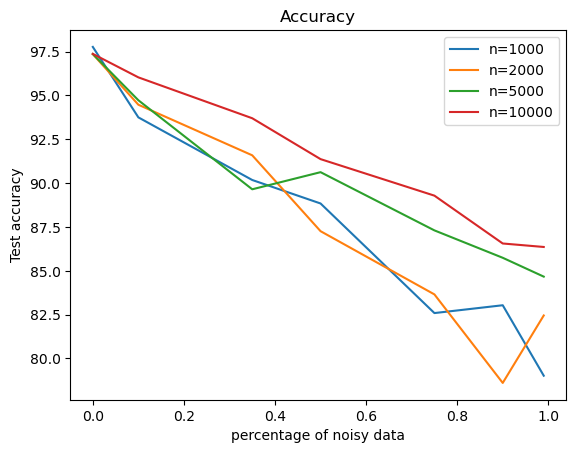

In [16]:
## PLotconsidering one realization per scenario
plt.plot(noise_props, accuracy_test[0,],label = f'n={n_samples[0]*2}')
plt.plot(noise_props, accuracy_test[1,],label = f'n={n_samples[1]*2}')
plt.plot(noise_props, accuracy_test[2,],label = f'n={n_samples[2]*2}')
plt.plot(noise_props, accuracy_test[3,],label = f'n={n_samples[3]*2}')
plt.xlabel('percentage of noisy data')
plt.ylabel('Test accuracy')
plt.title('Accuracy')
plt.legend()